In [1]:
jtplot.reset()
%matplotlib inline
from structurefunction import structure_function
import numpy as np
from astropy.table import Table
from astropy.coordinates import SkyCoord
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import astropy.units as u

The second-order structure function of rotation measure (RM) is given by:

$$ SF_{\text{RM},\text{obs}}(\delta\theta) = \langle[\text{RM}{\theta} - \text{RM}(\theta+\delta\theta)]^2\rangle$$

That is, the ensemble average of the squared-difference in RM for sources with angular seperation $\delta\theta$. We also need to correct for the impact of errors by:

$$ SF_{\text{RM}}(\delta\theta) = SF_{\text{RM},\text{obs}}(\delta\theta) - SF_{\sigma_\text{RM}}(\delta\theta) $$

See Haverkorn et al. 2004 (2004ApJ...609..776H) for details.

Here we'll reproduce the results of Mao et al. 2010 (2010ApJ...714.1170M).

First, we can look at the expected results. I've pulled these data from the paper's plots using a web plot digitiser.

In [2]:
mao_sf = 10**np.array([2.417894195735458,
                    2.097768739428083,
                    2.2926445508823967,
                    2.164149088774578,
                    2.1404402085381147,
                    2.176621779798478,
                    2.218782670913379,
                    2.2444782900152482,
                    2.2476963207124476,
                    2.2837806390213578,]) * (u.rad / u.m**2)**2
mao_sep = 10**np.array([-0.7729091483767441, 
                    -0.5386163683663935, 
                    -0.2730532911440767, 
                    -0.02550632317850443, 
                    0.21819567988496358, 
                    0.47213008276920787, 
                    0.7173429798998987, 
                    0.9643533199726302, 
                    1.18882007856649, 
                    1.3453070240944185,]) * u.deg

Text(0, 0.5, 'RM SF [$\\mathrm{rad^{2}\\,m^{-4}}$]')

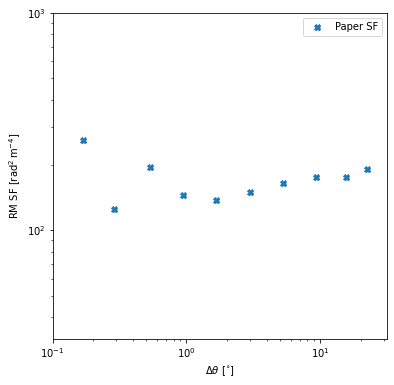

In [3]:
plt.figure(figsize=(6,6))
plt.plot(mao_sep, mao_sf, 'X', label='Paper SF')
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**1.5, 10**3)
plt.xlim(10**-1,10**1.5)
plt.legend()
plt.xlabel(rf"$\Delta\theta$ [{mao_sep.unit:latex_inline}]")
plt.ylabel(rf"RM SF [{mao_sf.unit:latex_inline}]")

Now we'll start with the original data. We'll convert the data to an astropy table for convenience

In [4]:
with open('apj343194t1_mrt.txt') as f:
    lines = f.readlines()
for i, line in enumerate(tqdm(lines)):
    lines[i] = line.strip()
coords, rms, e_rms, flags, incs = [], [], [], [], []
for i, line in enumerate(tqdm(lines)):
    ra = f"{line[0:2]}h{line[3:5]}m{line[6:11]}s"
    #print(ra)
    dec = f"{line[12]}{line[13:15]}d{line[16:18]}m{line[19:24]}s"
    coord = SkyCoord(ra, dec)
    rm = float(line[39:42]) * (u.rad / u.m**2)
    e_rm = float(line[43:45]) * (u.rad / u.m**2)
    inc = line[63] == 'Y'
    incs.append(inc)
    try:
        flag = line[67]
    except:
        flag = None
    coords.append(coord)
    rms.append(rm)
    e_rms.append(e_rm)
    flags.append(flag)

mao_rm_tab = Table()
mao_rm_tab.add_column(coords, name='coordinates')
mao_rm_tab.add_column(rms, name='RM')
mao_rm_tab.add_column(e_rms, name='e_RM')
mao_rm_tab.add_column(incs, name='included')
mao_rm_tab.add_column(flags, name='flag')

mao_rm_tab

100%|██████████| 472/472 [00:00<00:00, 1145.59it/s]


coordinates,RM,e_RM,included,flag
"deg,deg",rad / m2,rad / m2,,
object,float64,float64,bool,object
"196.78470833333333,24.78352777777778",-3.0,4.0,True,None
"203.9505833333333,20.171111111111113",3.0,5.0,False,b
"201.06033333333332,22.220305555555555",-6.0,6.0,True,None
"201.07991666666663,22.233472222222222",0.0,6.0,True,None
"199.01816666666664,23.62713888888889",4.0,13.0,True,None
"200.20225,22.965194444444442",-6.0,8.0,True,None
"197.81804166666666,24.454333333333334",5.0,3.0,True,None
"203.60637499999996,21.167916666666667",-1.0,9.0,False,b


f

Now we'll define our own bin edges to compute a structure function

In [5]:
start = -0.8
stop = 1.5
step = 0.1
bins = 10**np.arange(start, stop+step, step)*u.deg

Here we compute the strcture function itself, including error correction. We use 1000 samples of each distribution for error propagation.

By setting `show_plots=True` three plots are shown. 
1. An error-bar plot of the SF with a comparison line to a 2D kolmogorov spectrum
2. A count of the number of source pairs per SF bin
3. A structure function image showing the sampling from Monte-Carlo error propagation

The `structure_function` function returns the centre of each bin, the median value of each bin, the upper and lower error bounds, and the number of sources in each bin.

Sampling errors...


Sample Gaussian: 100%|██████████| 400/400 [00:00<00:00, 11516.72it/s]

Getting data differences...


Getting data error differences...
Getting angular separations...
Computing SF...


 52%|█████▏    | 13/25 [00:00<00:00, 111.34it/s]/Users/tho822/GoogleDrive/repos/structurefunction/structurefunction.py:93: RuntimeWarning: Mean of empty slice
  sf_dist = np.nanmean(diffs_dist[:, bin_idx], axis=1)
/Users/tho822/GoogleDrive/repos/structurefunction/structurefunction.py:94: RuntimeWarning: Mean of empty slice
  d_sf_dist = np.nanmean(d_diffs_dist[:, bin_idx], axis=1)
 96%|█████████▌| 24/25 [00:02<00:00, 11.83it/s] 
/Users/tho822/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:993: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanmedian1d, axis, a, overwrite_input)
/Users/tho822/miniconda3/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,
100%|██████████| 24/24 [00:02<00:00,  8.54it/s]
/Users/tho822/GoogleDrive/repos/structurefunction/structurefunction.py:155: MatplotlibDeprecationWarning: shading='flat' when X and Y h

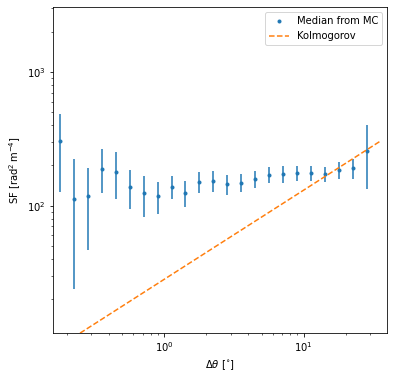

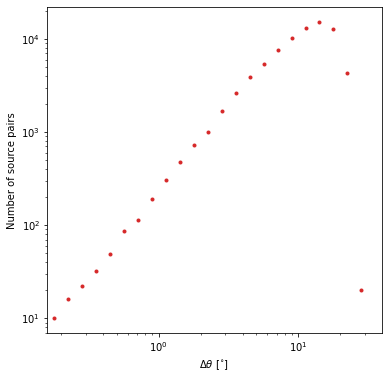

<Figure size 432x288 with 0 Axes>

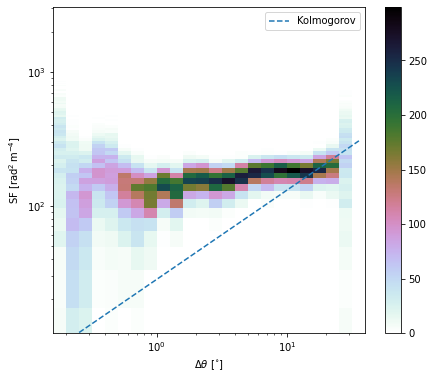

In [6]:
cbins, medians, err, count = structure_function(
    mao_rm_tab['RM'][mao_rm_tab['included']],
    mao_rm_tab['e_RM'][mao_rm_tab['included']],
    mao_rm_tab['coordinates'][mao_rm_tab['included']],
    1000,
    bins,
    show_plots=True,
    verbose=True,
    
)

Finally, we can compare our results to those from the original paper.

Text(0, 0.5, 'RM SF [$\\mathrm{rad^{2}\\,m^{-4}}$]')

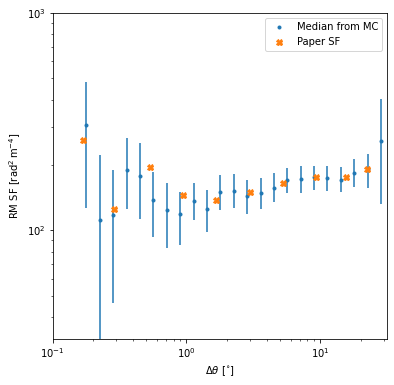

In [7]:
plt.figure(figsize=(6,6))
plt.plot(cbins, medians, '.', label='Median from MC')
plt.errorbar(cbins.value, medians, yerr=err, color='tab:blue', marker=None, fmt=' ', )#label = '16th to 84th percentile range')
plt.plot(mao_sep, mao_sf, 'X', label='Paper SF')
plt.xscale('log')
plt.yscale('log')
plt.ylim(10**1.5, 10**3)
plt.xlim(10**-1,10**1.5)
plt.legend()
plt.xlabel(rf"$\Delta\theta$ [{mao_sep.unit:latex_inline}]")
plt.ylabel(rf"RM SF [{mao_sf.unit:latex_inline}]")